# Import packages

In [204]:
import torch
import torch.nn as nn
import torchdiffeq
import time
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import scipy.optimize as opt
import numpy as np
import pickle
import emcee
from joblib import Parallel, delayed, effective_n_jobs
import imageio

torch.set_default_dtype(torch.float)
print("Number of workers available: ", effective_n_jobs(-1))

Number of workers available:  36


# Define classes for parameter-container and sequence generator

In [205]:
"""
Class MassFricParams, manages data of a mass block sliding on rate-and-state friction surface, contains 
    Data:
        k : Spring stiffness
        m : Mass of the block
        V : Leading head speed of the spring
        g : Gravity
        RSParams : rate and state parameters, torch.tensor([a, b, DRS, f*])
        y0 : torch.tensor([initial x_1, initial v_1, initial state variable])
"""
class MassFricParams: 
    # Constructor
    def __init__(self, k, m, V, g, RSParams, y0):
        self.k = k
        self.m = m
        self.V = V
        self.g = g
        self.RSParams = RSParams
        self.y0 = y0
    
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Mass and spring parameters ", "-"*20)
        print('k:        ', self.k)
        print('g:        ', self.g)
        print('m:        ', self.m)
        print('\n')
        
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.RSParams[3])
        print('a:        ', self.RSParams[0])
        print('b:        ', self.RSParams[1])
        print('DRS:      ', self.RSParams[2])
        print('y0:       ', self.y0)
        

In [206]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        MFParams: Mass and friction parameters for the system
        T: Length of calculation
        
    Method:
        __init__ : Constructor
        calculateYAtT: Generate the sequence of [x_1, v_1, theta]
        
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, T, NofTPts, MFParams, rtol = 1.e-6, atol = 1.e-8, regularizedFlag = True):
        # Load the parameters
        self.T = T
        self.t = torch.linspace(0., T, NofTPts)
        self.MFParams = MFParams
        self.rtol = rtol
        self.atol = atol
        self.regularizedFlag = regularizedFlag
        
        # Generate the sequence
        st = time.time()
        self.default_y = self.calculateYAtT(self.t)
        self.time_cost = time.time() - st
        print("Time cost to generate the sequence: ", self.time_cost)
        
    # Function DyDt, DyDt = f(t, y)
    def DyDt(self, t, y):
        
        # Need to use regularized rate-and-state
        a = self.MFParams.RSParams[0]
        b = self.MFParams.RSParams[1]
        DRS = self.MFParams.RSParams[2]
        fStar = self.MFParams.RSParams[3]
        
        # Regularized rate-and-state friction
#         tau = self.N * a * torch.asinh(
#                    self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
#                    )
        
        if self.regularizedFlag:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.V * t - y[0]) - \
                                 self.MFParams.g * (a * torch.asinh(
                                     y[1] / 2.e-6 * torch.exp((fStar + b * torch.log(1.e-6 * y[2] / DRS)) / a)
                                 )), 
                                 1 - y[2] * 1.e-6 / DRS])
        else:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.V * t - y[0]) - \
                                 self.MFParams.g * (fStar + \
                                                    a * torch.log(y[1] / 1.e-6) + \
                                                    b * torch.log(1.e-6 * y[2] / DRS)), 
                                 1 - y[2] * 1.e-6 / DRS])             
        # DEBUG LINES
#         print("-" * 30)
#         print('t = ', t)
#         print('y = ', y)
#         print('DyDt = ', DyDt)
        
        return DyDt
    
    
    # Generate the sequence of y(t) = [x_1(t), v_1(t), theta(t)]
    def calculateYAtT(self, t):
        y = odeint(self.DyDt, self.MFParams.y0, t, 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        return torch.transpose(y, 0, 1)
    
    # Visualize the sequence of y
    def plotY(self, t, y):
        # Plot Sequence of V(t) and N(t) given sample-index
        f, axs = plt.subplots(2, 2, figsize = (15, 15))

        # Plot x_1(t)
        axs[0][0].plot(1e6 * t, y[0, :], linewidth=2.0)
        axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][0].set_ylabel('Slip $x_1(t)\  \mathrm{[m]}$', fontsize=20)
        # axs[0][0].set_ylim([1e-15, 1e2])
        axs[0][0].grid()

        # Plot v_1(t)
        axs[0][1].semilogy(1e6 * t, y[1, :], linewidth=2.0)
        axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][1].set_ylabel('Slip rate $v_1(t)\ \mathrm{[m/s]}$', fontsize=20)
        # axs[0][1].set_ylim([0, 15])
        axs[0][1].grid()

        # Plot theta(t)
        axs[1][0].semilogy(1e6 * t, y[2, :], linewidth=3.0)
        axs[1][0].semilogy(1e6 * t, self.MFParams.RSParams[2] / y[1, :], linewidth=2.0)
        axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
        axs[1][0].legend(['True', 'Steady state'], loc='best', fontsize=20)
        axs[1][0].grid()

#         # Plot \tau(t)
#         axs[1][1].plot(1e6 * t, tauAll[sample_idx, :], linewidth=2.0)
#         axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
#         axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
#         axs[1][1].grid()

#         f.suptitle("The " + str(sample_idx) + "th sequence", fontsize = 20)


In [236]:
# Class RunABatch
class RunABatch:
    # Constructor
    def __init__(self, input_set,                                          # Inputs to run
                 T, NofTPts, rtol, atol, regularizedFlag, exampleMF,       # TimeSeqGeneration parameters
                 fourierTerms = 16, nThreads = 16, fourierFlag = False):
        
        # Initialize data paths and batch parameters
        self.input_set = [tuple(i) for i in input_set]
        self.T = T
        self.NofTPts = NofTPts
        self.rtol = rtol
        self.atol = atol
        self.regularizedFlag = regularizedFlag
        
        # MF Parameters
        self.k = exampleMF.k
        self.m = exampleMF.m
        self.V = exampleMF.V
        self.g = exampleMF.g
        self.y0 = exampleMF.y0
        
        self.FourierTerms = fourierTerms
        self.FourierFlag = fourierFlag
        self.nThreads = nThreads
        
        # Flag for whether cases have been run
        self.casesExcuted = False
        
        # Get input_set_toRun
        self.input_set_toRun = list(set(self.input_set))
        
        # Run cases
        self.rawSeqs = self.runCases(self.input_set_toRun, self.nThreads)
        
        # Get obsevations
        self.Observations = self.getObservations()
        
    # Function runCases
    def runCases(self, input_set, nThreads):
        # Start the timer
        st_time = time.time()

        # Divide the input_set into nThreads subsets
        if nThreads > len(input_set):
            nRealThreads = len(input_set)
        else:
            nRealThreads = nThreads
        
        if nRealThreads > 0:
            # Split with Real thread numbers
            split_input_set = np.array_split(input_set, nRealThreads)
            split_threadNo = list(range(1, nRealThreads + 1))
            
#             # Print splits
#             for inputSet, tNo in zip(split_input_set, split_threadNo):
#                 print(inputSet, tNo)
            
            # Submit the jobs
            sequences = Parallel(n_jobs=nRealThreads)(#, backend='threading')(
                delayed(self.runCasesOneThread)(inputSet, tNo) for inputSet, tNo in zip(split_input_set, split_threadNo)
            )
        else:
            time_thread = [0.]
        
        # Get running time
        time_cost = time.time() - st_time
        
        # Print running time
        # print("Wall clock time to run all inputs: ", time_cost)
        
        # Return from shell
        self.casesExcuted = True
        
        # Return raw sequences
        rawSeqs = torch.concat(sequences, 0)
        
        return rawSeqs 
    
    # Function runCasesOneThread
    def runCasesOneThread(self, input_set, threadNo):
        # Run sequences in input_set one by one
        sequences = []
        for ipt in input_set:
            MFParams = MassFricParams(self.k, self.m, self.V, self.g, torch.tensor(ipt), self.y0)
            iptSeq = TimeSequenceGen(self.T, self.NofTPts, MFParams, rtol = self.rtol, 
                                     atol = self.atol, regularizedFlag = self.regularizedFlag)
            
            sequences.append(iptSeq.default_y[1, :].reshape([1, -1]))
        
        # Return time
        return torch.concat(sequences, 0)
    
    # Function getObservations for the input_set
    def getObservations(self):
        # Initialize Observations
        Observations = []
        
        # Check if the cases have been excuted
        if self.casesExcuted == False:
            return Observations
        
        # Get the observations
        if self.FourierFlag:
    
            # Compute the Fourier terms
            self.times = torch.linspace(0., self.T, self.NofTPts)
            Ks = torch.tensor(range(self.FourierTerms))
            coskPiTt = torch.cos(Ks.reshape([-1, 1]) * torch.pi / self.T * self.times)
            
            for Vxi in self.rawSeqs:
                VxcoskPiTt = coskPiTt * Vxi.reshape([1, -1])
                
                # Compute the fourier coefficients
                # print('time.shape: ', time.shape)
                observation = torch.trapezoid(VxcoskPiTt, x=self.times).reshape([1, -1])
                # print("observation shape: ", observation.shape)
                # Append the result from this file
                Observations.append(observation)
            
            Observations = torch.concat(Observations, 0)
            
        else:
            # Find self.FourierTerms terms of values, evenly spaced in [0, T]
            self.times = torch.linspace(0., self.T, self.NofTPts)
            self.tts = torch.linspace(0., self.T, self.FourierTerms)
            # print("Times size: ", self.times.shape)
            # print("self.rawSeqs size: ", self.rawSeqs.shape)
            observation_func = interp1d(self.times, self.rawSeqs)
            Observations = torch.tensor(observation_func(self.tts))
            
            # DEBUG LINES Print Observations shape
            # print("Observations shape: ", Observations.shape)
        return Observations
    
    

# Gaussian Predictor

In [237]:
# Import Gaussian-regression related functions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Pre-process the data
from sklearn import preprocessing

# function train_GP
class GP_predictor:
    # Constructor
    def __init__(self, 
                 input_set, 
                 observation_set, 
                 GPkernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e3)), 
                 n_optimizers = 9):
        # Scale input data
        self.input_set = [list(x) for x in input_set]
        self.observation_set = [list(x) for x in observation_set]
        self.input_dimension = len(self.input_set[0])
        self.observation_dimension = len(self.observation_set[0])
        self.trainset_length = len(self.input_set)
        
        self.input_scaler = preprocessing.StandardScaler()
        self.input_scaler.fit(np.array(self.input_set))
        
        # Scale output data
        self.observation_scaler = preprocessing.StandardScaler()
        self.observation_scaler.fit(np.array(observation_set))
        
        # Fit Gaussian process
        self.GP = GaussianProcessRegressor(kernel = GPkernel, n_restarts_optimizer = n_optimizers)
        # self.GP = MyGPR(kernel = GPkernel, n_restarts_optimizer = n_optimizers, max_iter = max_iterations)
        self.GP.fit(self.input_scaler.transform(np.array(self.input_set)), 
                    self.observation_scaler.transform(np.array(self.observation_set)))
        
    # Predict on a new input set
    def predict(self, new_input_set):
        # Predict new observation
        new_observation = self.observation_scaler.inverse_transform(
            self.GP.predict(
                self.input_scaler.transform(np.array(list(new_input_set)).reshape([-1, self.input_dimension]))
            )
        )
        
        return new_observation
        
    

# Gaussian Process Regressor

In [253]:
# Define Bayersian Inv that solves a Bayersian inversion problem
class BayersianInv:
    # Constructor
    def __init__(self, u_low, u_high, u, y, T, NofTPts, exampleMF, fourierTerms = 16, 
                 rtol = 1.e-6, atol = 1.e-8, si_eta = 0.5, n_samples = 20, MCMCsteps = 1000, nThreads = 16, 
                 save_path = "./", regularizedFlag = False, fourierFlag = False, samplesFlag = 'sampling'):
        # Set X has to be compact in R^k
        self.real_u_idx = np.array((u_low != u_high))
        self.u_low = np.array(u_low[self.real_u_idx])
        self.u_high = np.array(u_high[self.real_u_idx])
        self.dummy_u = np.array(u_low[~self.real_u_idx])
        
        
        # For each iteration, needs a region to build the grid points
        self.u_lows = [u_low]
        self.u_highs = [u_high]
        
        # Store all the Rectangles
        self.Rects = [[np.array(self.u_low), np.array(self.u_high)]] 
        self.RectsArea = [np.product(self.u_high - self.u_low)]
        
        # The true value of u, as well as the observation y to be inverted
        self.u = np.array(u)
        self.y = np.array(y)
        
        # Other parameters
        self.input_dim_All = len(u_low)
        self.input_dim = len(self.u_low)
        self.output_dim = len(self.y)
        self.MF = exampleMF
        self.T = T
        self.NofTPts = NofTPts
        self.FourierTerms = fourierTerms
        self.atol = atol
        self.rtol = rtol
        
        self.si_eta = si_eta
        self.n_samples = n_samples
        self.MCMCsteps = MCMCsteps
        self.nThreads = nThreads
        self.save_path = save_path
        
        # Store flags
        self.RegularizedFlag = regularizedFlag
        self.FourierFlag = fourierFlag
        self.SamplesFlag = samplesFlag
        
        # Keep records of the sampled points and the corresponding observations after iteration
        self.U = np.empty([0, self.input_dim])
        self.O = np.empty([0, self.output_dim])
        self.iterations = 0
        
        # Keep record of eta, MaxMinLenRatio, GaussianProcess Emulator, average error on the sampled points, 
        # and empirical mean and stdv of the posterior after each iteration
        self.etas = []
        self.maxMinDistRatio = []
        self.GPs = []
        self.avg_errors = []
        self.mean = []
        self.stdv = []
        
        # Maximum likelihood points
        self.maxLikelihoodUs = [(self.u_low + self.u_high) / 2]
        self.maxLikelihoodUsPropL2Error = []
        self.maxLikelihoodObsPropL2Error = []
    
    # Cast u into the same length of u_low, with dummy u
    def castU(self, u_real):
        # print("u_real shape: ", u_real.shape)
        u_real_this = u_real.reshape([-1, self.real_u_idx.sum()])
        # print("u_real_this shape: ", u_real_this.shape)
        
        res = np.zeros([u_real_this.shape[0], len(self.u)])
        res[:, self.real_u_idx] = u_real_this
        res[:, ~self.real_u_idx] = self.dummy_u
        return res
    
    # Get the accumulative probability function
    def log_prob(self, u, y):
        # Apply hard constraints
        u_reshape = u.reshape([-1, self.input_dim])
        normal_idx = np.all(
            np.concatenate(
                [u_reshape >= self.u_low, u_reshape <= self.u_high], axis = 1
            ), 
            axis = 1
        )
       
        # First prior is uniform distribution
        res = np.ones(len(u_reshape))
        res[~normal_idx] = -np.inf
        
        # Add all posteriors in each iteration (since this is log of probability density)
        if (np.sum(normal_idx) > 0):
            for i in range(self.iterations):
                res[normal_idx] += -0.5 / self.etas[i] ** 2 * (
                    np.sum(
                        np.array((y - self.GPs[i].predict(u_reshape[normal_idx])) ** 2), 
                        axis = 1
                    )
                )
        
        # Return the log_probability at the current iteration
        return res
    
    # Compute statistics: sample and calculate mean and stdv
    def compute_stats(self, n_samples, n_steps = 1_000):
#         # Sample for more points to update the empirical statistics
#         sampler = emcee.EnsembleSampler(n_samples, 
#                                         self.input_dim, 
#                                         self.log_prob, args=[y], 
#                                         vectorize = True)

#         # Initialize uniformly as the starting point
#         p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low

#         # Get the result
#         sampler.run_mcmc(p0, n_steps)
#         samples = sampler.get_last_sample().coords
#         self.mean.append(np.mean(samples, axis = 0))
#         self.stdv.append(np.std(samples, axis = 0))
        
        # Get maximum likelihood estimate
        fun = lambda u: -self.log_prob(u, self.y)
        newCenter = opt.minimize(fun, x0 = np.mean(self.samples, axis = 0), 
                                 bounds = [(self.u_low[i], self.u_high[i]) for i in range(len(self.u_low))]
                                ).x
        
        self.maxLikelihoodUs.append(newCenter)
        
        self.maxLikelihoodUsPropL2Error.append(
            np.linalg.norm(self.u[self.real_u_idx] - self.maxLikelihoodUs[-1]) 
            / np.linalg.norm(self.u[self.real_u_idx])
        )
        self.maxLikelihoodObsPropL2Error.append(
            np.linalg.norm(self.y - self.GPs[-1].predict(self.maxLikelihoodUs[-1])) 
            / np.linalg.norm(self.y)
        )
        
#         # Run one case on newCenter
#         newCenterSeq = RunABatch(newCenter.reshape([1, -1]), self.T, self.NofTPts, self.rtol, self.atol, 
#                                  self.RegularizedFlag, 
#                                  self.MF,       # TimeSeqGeneration parameters
#                                  self.FourierTerms, self.nThreads, self.FourierFlag)
        
#         self.maxLikelihoodObsPropL2Error.append(
#             np.linalg.norm(self.y - np.array(newCenterSeq.Observations[0])) 
#             / np.linalg.norm(self.y)
#         )
        
        # Find the new rectangle
        
        
#         # Function to determine if a point is in the rectangles
#         def isInRectangle(setOfRects, pt):
#             res = [ for rec in setOfRects]
        
    # Get average error of a batch
    def get_avg_error_of_a_batch(self, myBatch):
        ## DEBUG LINES
        # print("myBatch.Observations.shape: ", myBatch.Observations.shape)
        # print("self.y.shape: ", self.y.shape)
        # res = (myBatch.Observations - self.y.reshape([1, -1])) ** 2
        # print("res shape: ", res.shape)
        return np.mean(np.sum(np.array((myBatch.Observations - self.y.reshape([1, -1])) ** 2), axis = 1))
    
    # Run one iteration
    def runOneIteration(self, n_samples, n_stat_samples):
        # Switch based on samplesFlag
        if self.SamplesFlag == 'sampling':
            # Sample from the current distribution for u and get the current observations
            sampler = emcee.EnsembleSampler(n_samples, 
                                            self.input_dim, 
                                            self.log_prob, args=[y], 
                                            vectorize = True)

            # Initialize uniformly as the starting point
            p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low

            # Get the result
            sampler.run_mcmc(p0, self.MCMCsteps)
            self.samples = sampler.get_last_sample().coords

            # If there is self_etas, this is to make sure MaxMinDistRatio does not go too large
            if len(self.etas) > 0:
                eta_times = 0
                while (eta_times < 2) and (MaxMinDistRatio(self.samples) > 100.):
                    # Double the last eta
                    self.etas[-1] = 2. * self.etas[-1]
                    eta_times += 1

                    # Re-sample
                    sampler = emcee.EnsembleSampler(n_samples, 
                                                    self.input_dim, 
                                                    self.log_prob, args=[y], 
                                                    vectorize = True)

                    # Initialize uniformly as the starting point
                    p0 = np.random.uniform(size = [n_samples, self.input_dim]) * (self.u_high - self.u_low) + self.u_low

                    # Get the result
                    sampler.run_mcmc(p0, self.MCMCsteps)
                    self.samples = sampler.get_last_sample().coords
                    MCsteps = 0
                    while (MCsteps < self.MCMCsteps / 10) and (MaxMinDistRatio(self.samples) > 10.):
                        sampler.run_mcmc(sampler.get_last_sample(), 1)
                        self.samples = sampler.get_last_sample().coords
                        MCsteps += 1

                # print("eta_times, MaxMinDistRatio: ", eta_times, MaxMinDistRatio(self.samples))
        
        elif self.SamplesFlag == 'grid':
            # DEBUG LINEs
            print("Before updating the rectangles")
            # print("self.samples.shape:, ", self.samples.shape)
            print("self.Rects length: ", len(self.Rects))
            print("self.RectsArea length: ", len(self.RectsArea))

            # Start with the point being maxLikelihoodUs[-1]
            self.samples = substituteRects(self.Rects, self.RectsArea, self.maxLikelihoodUs[-1], n_samples)
            
            # DEBUG LINEs
            print("After updating the rectangles")
            print("self.samples.shape:, ", self.samples.shape)
            print("self.Rects length: ", len(self.Rects))
            print("self.RectsArea length: ", len(self.RectsArea))

        # Run the forward map with the samples
        myBatch = RunABatch(self.samples, self.T, self.NofTPts, self.rtol, self.atol, self.RegularizedFlag, 
                            self.MF,       # TimeSeqGeneration parameters
                            self.FourierTerms, self.nThreads, self.FourierFlag)
#         myBatch = RunABatch(self.castU(self.samples), self.work_path, FourierTerms = self.FourierTerms, 
#                             distanceAbove = self.distanceAbove, nOfQueryPts = self.nOfQueryPts, 
#                             obsFlag = self.obsFlag, fourierFlag = self.fourierFlag, nThreads = self.nThreads)
        self.U = np.append(self.U, self.samples, axis = 0)
        self.O = np.append(self.O, myBatch.Observations, axis = 0)

        # Get a new Gaussian process
        myGP = GP_predictor(self.samples, myBatch.Observations)
        # myGP = GP_predictor(self.U, self.O)

        # Update the recorded variables of the process
        self.GPs.append(myGP)
        self.iterations += 1
        self.etas.append(self.si_eta)
        self.avg_errors.append(self.get_avg_error_of_a_batch(myBatch))
        self.maxMinDistRatio.append(MaxMinDistRatio(self.samples))
        
        # Update stats
        self.compute_stats(n_stat_samples)
        
        # Converging flag False
        return False
    
    # Run function
    def run(self, n_iter_max = 10, n_stat_samples = 1000):
        for i in range(n_iter_max):
            # In each iteration
            print("="*30, " Iteration ", str(self.iterations), " ", "="*30)
            
            # Run one iteration
            start_time = time.time()
            converged = self.runOneIteration(self.n_samples, n_stat_samples)
            end_time = time.time()
            print("Time cost: ", str(end_time - start_time), " s")
            # print("Average error in this iteration: ", self.avg_errors[-1])
            print("Maximum to minimum distance in the sample points: ", self.maxMinDistRatio[-1])
            # print("Mean of the posterior after this iteration: ", self.mean[-1])
            # print("Stdv of the posterior after this iteration: ", self.stdv[-1])
            print("Max likelihood estimate of the posterior after this iteration: ", self.maxLikelihoodUs[-1])
            print("L2 error of u: ", self.maxLikelihoodUsPropL2Error[-1])
            print("L2 error of y: ", self.maxLikelihoodObsPropL2Error[-1])
        # Save the current model to files
        self.save()
        
    # Save the model to files
    def save(self):
        savePath = self.save_path + \
            "models/A{0}_B{1}_DRS{2}_fStar{3}_eta{4}-Fourier-{5}-{6}-samples-{7}.pickle".format(
            self.u[0], self.u[1], self.u[2], self.u[3], self.si_eta, 
            self.FourierFlag, self.FourierTerms, self.SamplesFlag)
        with open(savePath, 'wb') as file:
            pickle.dump(self, file)
    
    # Plot the regression process into a gif file
    def plotGIF(self):
        plotSeries(self, self.u[self.real_u_idx], self.y, self.save_path)

        
# ===================================== Other Auxiliary functions ==========================================
# Function MaxMinDistRatio, compute the ratio of maximum to minimum distance among pts, 
# for the gaussian process to converge with a reasonable length-scaled kernel, 
# this value should not be too large
def MaxMinDistRatio(pts):
    matrix = [[np.linalg.norm(pts[i] - pts[j]) for j in range(i + 1, len(pts))] for i in range(len(pts))]
    vec = [x for y in matrix for x in y]
    return max(vec) / min(vec)


# Calculate the corresponding (to y) log likelihood of iter_step on u
def log_prob_best(self, iter_step, u, y):
    # Apply hard constraints
    u_reshape = u.reshape([-1, self.input_dim])
    normal_idx = np.all(np.concatenate([u_reshape >= self.u_low, u_reshape <= self.u_high], axis = 1), axis = 1)

    # First prior is uniform distribution
    res = np.ones(len(u_reshape))
    res[~normal_idx] = -np.inf

    # Add all posteriors in each iteration
    if (np.sum(normal_idx) > 0):
        for i in range(iter_step + 1):
            res[normal_idx] += -0.5 / self.etas[i] ** 2 * (
                np.sum(
                    (y - self.GPs[i].predict(u_reshape[normal_idx])) ** 2, 
                    axis = 1
                )
            )

    # Return the log_probability at the current iteration
    return res

# Plot the given regression process on (analytical_u, analytical_y) and save the GIF
def plotSeries(self, analytical_u, analytical_y, save_path, dpi_value = 300):
    # Calculate U_plot
    minU = self.u_low
    maxU = self.u_high
    nOfGridPoints = 100

    xis = []
    for i in range(minU.shape[0]):
        xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

    # Generate grid and draw predictions
    UPlotGrid = np.meshgrid(xis[0], xis[1])
    UPlotGrid = np.stack(UPlotGrid, axis = 2)
    UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
    
    gifName = save_path + "figures/A{0}_B{1}.gif".format(analytical_u[0], analytical_u[1])
    
    writer = imageio.get_writer(gifName, mode='I', duration = 1.0)
    
    # Maximum likelihood points
    self.maxLikelihoodUs = []
    self.maxLikelihoodUsPropL2Error = []
    self.maxLikelihoodObsPropL2Error = []
    
    # Plot the series
    for i in range(0, self.iterations):
        plt.figure(figsize = (7, 6), dpi = dpi_value)
        YPlotGridFat = log_prob_best(self, i, UPlotGridFat, analytical_y)
        YPlotGridFat = YPlotGridFat - np.max(YPlotGridFat)
        
        # Get optimized u
        idx = np.argmax(YPlotGridFat)
        
        # self.maxLikelihoodUs.append(UPlotGridFat[idx])
        
        fun = lambda u: -log_prob_best(self, i, u, analytical_y)
        newCenter = opt.minimize(fun, x0 = UPlotGridFat[idx], 
                                 bounds = [(self.u_low[i], self.u_high[i]) for i in range(len(self.u_low))]
                                ).x
        
        # DEBUG LINES
        # print("=" * 60)
        # print("i, u = ", i, newCenter)
        
        # print("-fun(u_opt), log_prob_best(u_opt): ", -fun(newCenter), log_prob_best(self, i, newCenter, analytical_y))
        # print("-fun(grid_opt), log_prob_best(grid_opt): ", -fun(UPlotGridFat[idx]), log_prob_best(self, i, UPlotGridFat[idx], analytical_y))
        self.maxLikelihoodUs.append(newCenter)
        
        self.maxLikelihoodUsPropL2Error.append(
            np.linalg.norm(analytical_u - self.maxLikelihoodUs[-1]) 
            / np.linalg.norm(analytical_u)
        )
        self.maxLikelihoodObsPropL2Error.append(
            np.linalg.norm(analytical_y - self.GPs[i].predict(self.maxLikelihoodUs[-1])) 
            / np.linalg.norm(analytical_y)
        )
        
        YPlotGrid = YPlotGridFat.reshape([nOfGridPoints, nOfGridPoints])
        cp = plt.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], np.maximum(YPlotGrid, -5.))
        
        # Give the color bar
        cbar = plt.colorbar(cp)
        plt.clim([-5., 0.])
        cbar.set_label('$-\\Phi(u)$', fontsize = 20)
        
        # Scatter the sample points
        plt.scatter(self.U[ :(i + 1) * self.n_samples, 0], 
                    self.U[ :(i + 1) * self.n_samples, 1], s = 1, color = 'white')
        plt.scatter(analytical_u[0], analytical_u[1], s = 15, color = 'red')
        plt.xlabel('$u_1$', fontsize = 20)
        plt.ylabel('$u_2$', fontsize = 20)
        plt.title("The " + str(i) + " th iteration")
        figName = save_path + "figures/shit" + str(i) + ".png"
        plt.savefig(figName, dpi = dpi_value)
        
        # Save the figures into a gif
        image = imageio.imread(figName)
        writer.append_data(image)
        !rm $figName
    writer.close()
    
    # Save a figure of L2PropError of u
    plt.figure(figsize = (7, 6), dpi = dpi_value)
    plt.scatter(range(1, 1 + len(self.maxLikelihoodUsPropL2Error)), self.maxLikelihoodUsPropL2Error, s = 20)
    plt.xlabel('Iteration', fontsize = 20)
    plt.ylabel('$\|u-u_{true}\|/\|u_{true}\|$', fontsize = 20)
    # plt.ylim([0., 0.01])
    plt.title('Relative L2 error of $u$', fontsize = 20)
    figName = save_path + "figures/A{0}_B{1}_propL2UError.png".format(analytical_u[0], analytical_u[1])
    plt.savefig(figName, dpi = dpi_value)

    # Save a figure of L2PropError of y
    plt.figure(figsize = (7, 6), dpi = dpi_value)
    plt.scatter(range(1, 1 + len(self.maxLikelihoodUsPropL2Error)), self.maxLikelihoodObsPropL2Error, s = 20)
    plt.xlabel('Iteration', fontsize = 20)
    plt.ylabel('$\|y-y_{true}\|/\|y_{true}\|$', fontsize = 20)
    # plt.ylim([0., 0.01])
    plt.title('Relative L2 error of $y$', fontsize = 20)
    figName = save_path + "figures/A{0}_B{1}_propL2YError.png".format(analytical_u[0], analytical_u[1])
    plt.savefig(figName, dpi = dpi_value)
    
    

## Give an example:

In [254]:
## Fixed parameters
# Parameters for the spring-slider
k = 50.
m = 1.
V = 1.
g = 9.8
y0 = torch.tensor([0., 1.0, 1.0])

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Other parameters
RegularizedFlag = False
FourierFlag = True
FourierTerms = 16
nThreads = 16

Time cost to generate the sequence:  0.6852965354919434


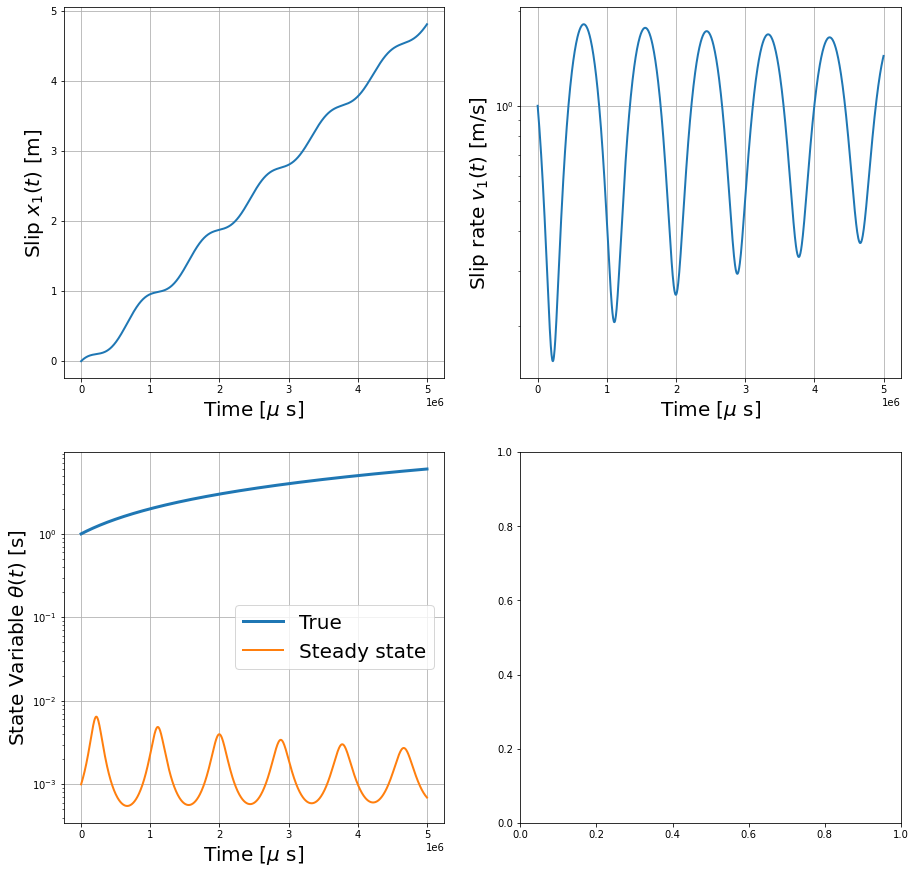

In [255]:
# Generate target v
targ_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
targ_SpringSlider = MassFricParams(k, m, V, g, targ_RSParams, y0)

targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, rtol=this_rtol, 
                           atol=this_atol, regularizedFlag=RegularizedFlag)
v = targ_seq.default_y[1, :]
targ_seq.plotY(targ_seq.t, targ_seq.default_y)

# Run Bayersian inversion

In [256]:
# Get target RSParams
Useq = RunABatch([targ_RSParams],                                   # Inputs to run
                 T, NofTPts, this_rtol, this_atol, RegularizedFlag, targ_SpringSlider,   # TimeSeqGeneration parameters
                 fourierTerms = FourierTerms, nThreads = nThreads, fourierFlag = FourierFlag)


u_low = np.array([0.008, 0.014, 0.5e-3, 0.3])
u_high = np.array([0.013, 0.019, 2.e-3, 0.6])
u = targ_RSParams
y = Useq.Observations[0, :]

Time cost to generate the sequence:  0.612525463104248


In [257]:
# Run inversion
myInv = BayersianInv(u_low, u_high, u, y, T, NofTPts, targ_SpringSlider, fourierTerms = 16, 
                 rtol = 1.e-6, atol = 1.e-8, si_eta = 0.5, n_samples = 256, MCMCsteps = 1000, nThreads = nThreads, 
                 save_path = "./", regularizedFlag=RegularizedFlag, fourierFlag = FourierFlag, samplesFlag = 'sampling')
myInv.run(n_iter_max = 10, n_stat_samples = 1000)

==============================  Iteration  0   ==============================
Time cost:  9.542910099029541  s
Maximum to minimum distance in the sample points:  4.787314991816922e+02
Max likelihood estimate of the posterior after this iteration:  [0.0103105  0.0164911  0.00126598 0.44646091]
L2 error of u:  0.23011561773416558
L2 error of y:  0.07833705845548954
==============================  Iteration  1   ==============================
Time cost:  46.53087544441223  s
Maximum to minimum distance in the sample points:  4.657793845247959e+02
Max likelihood estimate of the posterior after this iteration:  [0.01046311 0.01651379 0.0012577  0.44448131]
L2 error of u:  0.23352565521773797
L2 error of y:  0.07887997607604465
==============================  Iteration  2   ==============================
Time cost:  51.19691586494446  s
Maximum to minimum distance in the sample points:  4.983362402643429e+02
Max likelihood estimate of the posterior after this iteration:  [0.0105339  0.016523

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  56.795569896698  s
Maximum to minimum distance in the sample points:  538.8435156239437
Max likelihood estimate of the posterior after this iteration:  [0.01053658 0.01656249 0.00125908 0.44692879]
L2 error of u:  0.2293081704080439
L2 error of y:  0.07743696962404993
==============================  Iteration  4   ==============================


/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  60.90196752548218  s
Maximum to minimum distance in the sample points:  442.6557416013733
Max likelihood estimate of the posterior after this iteration:  [0.01042929 0.01644907 0.00123928 0.45068498]
L2 error of u:  0.22283564033741027
L2 error of y:  0.075234703781162
==============================  Iteration  5   ==============================
Time cost:  66.56599020957947  s
Maximum to minimum distance in the sample points:  5.286700417948551e+02
Max likelihood estimate of the posterior after this iteration:  [0.01050268 0.01678925 0.00122545 0.44914824]
L2 error of u:  0.22548586617409663
L2 error of y:  0.07690692680488793
==============================  Iteration  6   ==============================


/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  71.02307176589966  s
Maximum to minimum distance in the sample points:  1418.7126931718606
Max likelihood estimate of the posterior after this iteration:  [0.01060727 0.01627741 0.00126165 0.43907365]
L2 error of u:  0.24284187104425733
L2 error of y:  0.08030256886604968
==============================  Iteration  7   ==============================
Time cost to generate the sequence:  0.26576900482177734
Time cost to generate the sequence:  0.2581195831298828
Time cost to generate the sequence:  0.27596187591552734
Time cost to generate the sequence:  0.2662186622619629
Time cost to generate the sequence:  0.2610955238342285
Time cost to generate the sequence:  0.2614455223083496
Time cost to generate the sequence:  0.27570605278015137
Time cost to generate the sequence:  0.25511789321899414
Time cost to generate the sequence:  0.26455020904541016
Time cost to generate the sequence:  0.2530643939971924
Time cost to generate the sequence:  0.25741004943847656
Time cost to ge

/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  74.38029408454895  s
Maximum to minimum distance in the sample points:  676.6811722227343
Max likelihood estimate of the posterior after this iteration:  [0.0105472  0.01653775 0.00119153 0.45005244]
L2 error of u:  0.2239252348840138
L2 error of y:  0.07490904321249224
==============================  Iteration  8   ==============================


/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  77.59884762763977  s
Maximum to minimum distance in the sample points:  438.0403949315823
Max likelihood estimate of the posterior after this iteration:  [0.01046182 0.01652247 0.0012614  0.44992108]
L2 error of u:  0.2241522490721747
L2 error of y:  0.07573385649112897
==============================  Iteration  9   ==============================


/home/shengduo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Time cost:  83.18080615997314  s
Maximum to minimum distance in the sample points:  1290.4827113115064
Max likelihood estimate of the posterior after this iteration:  [0.01056362 0.01640741 0.00127388 0.45295912]
L2 error of u:  0.218915927181665
L2 error of y:  0.07346508188491167


In [449]:
# Report observation:
Obs = O(new_seq.default_y, v, new_seq.t, new_SpringSlider)
print('Observation vector: ', Obs)

Relative L2 error:  tensor(0.0006)
Observation vector:  tensor(0.0004)


In [450]:
# Calculate DoDBeta
myADJ = AdjDerivs(new_seq.default_y, v, new_seq.t, new_SpringSlider)


DODBeta:  tensor([-5.2888e-01,  1.0336e+00,  5.9254e-04, -7.1320e-02])


In [451]:
# Get the finite-difference gradients
perturbRatio = 0.01
numericalGrad = torch.zeros(new_RSParams.shape)

# Loop through all beta's components
for i in range(len(new_RSParams)):
    RSParamsPlus = torch.clone(new_RSParams)
    RSParamsPlus[i] = RSParamsPlus[i] * (1 + perturbRatio)
    RSParamsMinus = torch.clone(new_RSParams)
    RSParamsMinus[i] = RSParamsMinus[i] * (1 - perturbRatio)
    
    print("-" * 40)
    print("RSParams: ", new_RSParams)
    print("RSParamsPlus: ", RSParamsPlus)
    print("RSParamsMinus: ", RSParamsMinus)
    
    # Calculate two observations
    SpringSliderPlus = MassFricParams(k, m, V, g, RSParamsPlus, y0)
    seqPlus = TimeSequenceGen(T, NofTPts, SpringSliderPlus, regularizedFlag=False)
    OPlus = O(seqPlus.default_y, v, seqPlus.t, SpringSliderPlus)
    
    SpringSliderMinus = MassFricParams(k, m, V, g, RSParamsMinus, y0)
    seqMinus = TimeSequenceGen(T, NofTPts, SpringSliderMinus, regularizedFlag=False)
    OMinus = O(seqMinus.default_y, v, seqMinus.t, SpringSliderMinus)
    
    numericalGrad[i] = (OPlus - OMinus) / (RSParamsPlus[i] - RSParamsMinus[i])

print('Numerical gradient: ', numericalGrad)

----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 2.0000, 0.5800])
RSParamsPlus:  tensor([0.0111, 0.0160, 2.0000, 0.5800])
RSParamsMinus:  tensor([0.0109, 0.0160, 2.0000, 0.5800])
Relative L2 error:  tensor(0.0005)
Relative L2 error:  tensor(0.0006)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 2.0000, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0162, 2.0000, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0158, 2.0000, 0.5800])
Relative L2 error:  tensor(0.0007)
Relative L2 error:  tensor(0.0005)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 2.0000, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 2.0200, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 1.9800, 0.5800])
Relative L2 error:  tensor(0.0006)
Relative L2 error:  tensor(0.0006)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 2.0000, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 2.0000, 0.5858])
RSParamsMinus:  tensor(

In [439]:
(OPlus - Obs) / (perturbRatio * new_RSParams[3])

tensor(0.0184)